# scoreCT: Automated cell type annotation in scRNA-seq data
ScoreCT is a script allowing automated annotation of scRNA-seq data analyzed with Scanpy. Providing your own reference or using the reference regularly updated and provided with the package, you can automatically assign clusters from your Scanpy analysis pipeline to cell types.


In [7]:
# Run this if you open in Colab
# !pip install scanpy

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/LucasESBS/scoreCT/blob/master/example/tuto_scoreCT.ipynb)

## Requirements
### Clustering
scoreCT requires that your scanpy Anndata object contains a clustering field (_eg_: louvain, leiden), which will be used to assign cell types. See scanpy tutorial on how to run clustering on your data (typically running sc.tl.louvain(adata, args).
### Differential gene expression for cluster biomarkers
scoreCT will use the gene ranking from sc.tl.rank_gene_groups to assign cell types to cluster. This field has to be present in your Anndata object (in Anndata.uns). See scanpy tutorial and documentation on the details for this method.
### A reference containing cell types/markers
scoreCT is not relying on training data (as only a few datasets are consistently annotated at the time), but instead on a reference sheet for cell types and associated markers. See different option below (your own file, our draft reference, or the CellMarkerDB from Zhang et al.) 

## Standard Usage
Here, the user provide it's own csv as a reference. The wrangling and formating is left to the user as the reference table can take many different shapes. For an example, you can look at the file __ref_marker.gmt__ used in this example.

In [8]:
# Import modules
import os
import sys
import pandas as pd
import scanpy.api as sc

sys.path.append('../src/')
import scorect_api as ct

# Load example scRNA-seq data (already analyzed)
adata = sc.read('../data/week2_data_all.h5ad')

# Load reference table - scoreCT api provides a wrapper for gmt, tsv and csv formats.
ref_marker = ct.read_markers_from_file('../data/ref_marker.gmt')

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [9]:
# Run this if you didn't run scanpy rank_gene_groups() yet -- use raw slot of AnnData
sc.tl.rank_genes_groups(adata, groupby='louvain', n_genes=len(adata.raw.var), use_raw=True)

__Debugging__: Here, if an error is thrown, the raw slot of AnnData is probably empty. In this case, try to run:<br>
```python 
sc.tl.rank_genes_groups(adata, groupby='louvain', n_genes=len(adata.var), use_raw=False)```

In [10]:
# Wrangle results from existing sc.tl.rank_genes_groups() results
# Let's have a look for cluster 0
marker_df = ct.wrangle_ranks_from_anndata(adata)
print(marker_df.head())

Wrangling: Number of markers used in ranked_gene_groups:  30044
Wrangling: Groups used for ranking: louvain
     z_score      adj_pvals        gene cluster_number
0  42.329636  1.654726e-224       MGST1              0
1  34.191624  2.414172e-168        PRTG              0
2  33.602177  1.871338e-170       NR2F1              0
3  28.454294  3.978496e-135      IGFBP5              0
4  28.117767  7.285298e-130  AC018730.1              0


In [11]:
# Score cell types for each cluster 
# Let's set parameters first - K represents the number of genes included in the ranking
# m represents the number of bins used to divide the top K genes.
K = 300
m = 5
# Get the background genes - here, all the genes used to run the differential gene expression test
background = adata.raw.var.index.tolist()
# Now run the function
ct_pval, ct_score = ct.celltype_scores(nb_bins=m,
                                        ranked_genes=marker_df,
                                        K_top = K,
                                        marker_ref=ref_marker,
                                        background_genes=background)

__Help:__ The background genes correspond to all the gene used to run the differential test. If _raw_ was not used, use:
```python
background = adata.var.index.tolist()```

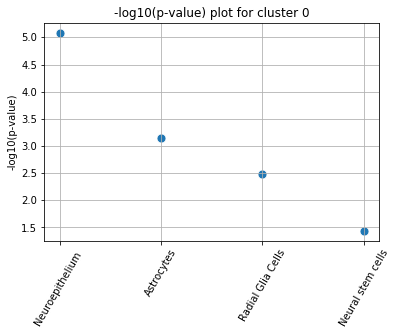

In [12]:
# Let's have a look at the pvalue for cluster 0
ct.plot_pvalue(ct_pval, clusters=0)

... storing 'scorect' as categorical


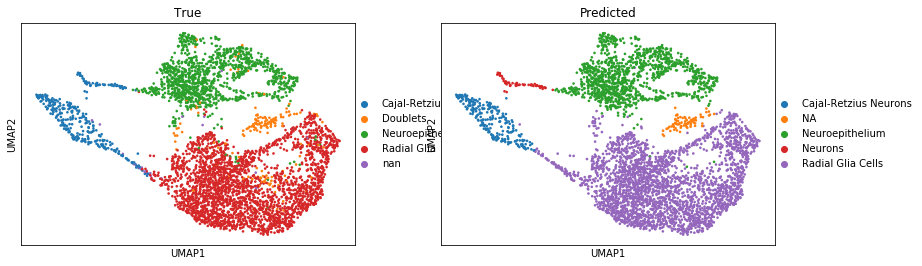

In [13]:
# Now assign clusters to cell types
cluster_assign = adata.obs['louvain']
celltype_assign = ct.assign_celltypes(cluster_assignment=cluster_assign, ct_pval_df=ct_pval, ct_score_df=ct_score, cutoff=0.1)
# Add to anndata object
adata.obs['scorect'] = celltype_assign
# Let's compare with the true assignment now! 
sc.pl.umap(adata, color=['cell_type','scorect'], title=['True','Predicted'])